<a href="https://colab.research.google.com/github/VladimirVladetic/OSiRV-RoadSignDetection/blob/main/EDA_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from imblearn.under_sampling import RandomUnderSampler
import xml.etree.ElementTree as ET
import pybboxes as pbx
from collections import defaultdict
from google.colab import files

In [ ]:
! pip install kaggle

In [14]:
! pip install pybboxes

In [5]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [6]:
! kaggle datasets download -d andrewmvd/road-sign-detection

100% 218M/218M [00:12<00:00, 22.9MB/s]
100% 218M/218M [00:12<00:00, 19.0MB/s]


In [7]:
with zipfile.ZipFile('/content/road-sign-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [8]:
annotations_path = '/content/annotations'
annotations = os.listdir(annotations_path)

In [ ]:
print(annotations)
print(len(annotations))

In [12]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

  0%|          | 0/877 [00:00<?, ?it/s]

In [16]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})

classes = labels_df['label'].unique().tolist()
classes

labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road859.png,300,400,128,151,153,176,speedlimit,0
1,road100.png,400,385,35,5,363,326,speedlimit,0
2,road241.png,300,400,136,200,155,218,speedlimit,0
3,road241.png,300,400,156,201,175,220,speedlimit,0
4,road244.png,300,400,155,212,174,231,speedlimit,0


In [17]:
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

  0%|          | 0/1244 [00:00<?, ?it/s]

In [18]:
print(img_dict)

defaultdict(<class 'list'>, {'road859.png': ['0 0.4683333333333333 0.40875 0.08333333333333333 0.0625'], 'road100.png': ['0 0.4975 0.42987012987012985 0.82 0.8337662337662337'], 'road241.png': ['0 0.485 0.5225 0.06333333333333334 0.045', '0 0.5516666666666666 0.52625 0.06333333333333334 0.0475'], 'road244.png': ['0 0.5483333333333333 0.55375 0.06333333333333334 0.0475', '0 0.615 0.5525 0.056666666666666664 0.045'], 'road144.png': ['1 0.53875 0.4692622950819672 0.5625 0.7827868852459017'], 'road166.png': ['1 0.2783333333333333 0.5225 0.20333333333333334 0.16'], 'road821.png': ['2 0.44 0.32375 0.16 0.1175', '1 0.5666666666666667 0.49625 0.15333333333333332 0.1225', '3 0.4483333333333333 0.5425 0.09666666666666666 0.205', '3 0.37 0.57875 0.05333333333333334 0.1325', '3 0.1 0.5725 0.05333333333333334 0.07', '3 0.011666666666666667 0.73375 0.023333333333333334 0.0625', '3 0.31666666666666665 0.7175 0.09333333333333334 0.105', '1 0.75 0.7075 0.04666666666666667 0.05'], 'road165.png': ['1 0.4

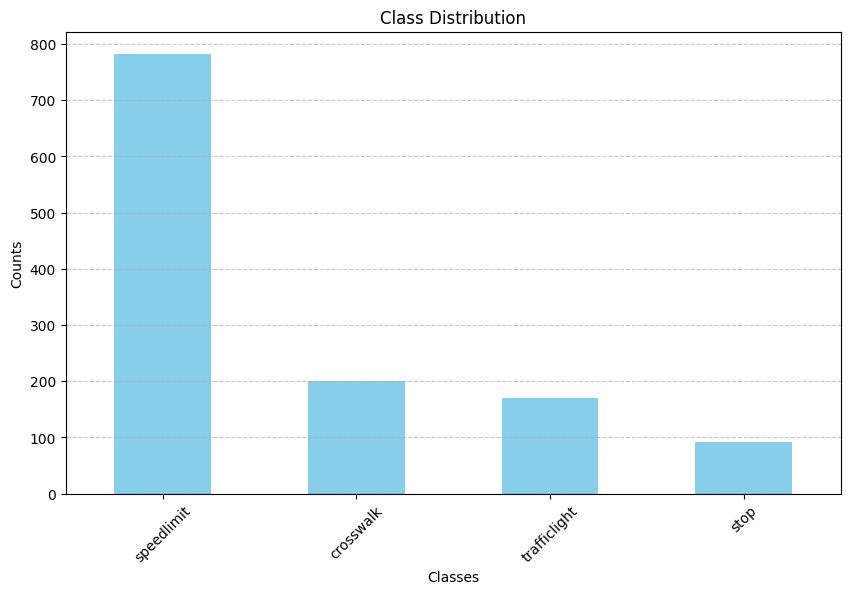

In [27]:
class_counts = labels_df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(labels_df['width'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(labels_df['height'], bins=30, color='red', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
train_augment_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
train_generator = train_augment_generator.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/images/',
    x_col='img_name',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 995 validated image filenames belonging to 4 classes.


In [ ]:
def extract_features(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = load_img(image, color_mode='grayscale')
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 1)
    features = np.array(features, dtype=np.float32)
    return features

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)